In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os import listdir, makedirs, getcwd, remove
print(os.listdir("../input"))

# Import packages
import time, copy
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torchvision.models.vgg import model_urls
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

from os.path import isfile, join, abspath, exists, isdir, expanduser

# Any results you write to the current directory are saved as output.

['pytorch-pretrained-models', 'pytorch-pretrained-image-models', 'iwildcam-2019-fgvc6', 'vgg19', 'inceptionv3', 'vgg16']


## Load dataset

In [2]:
# Class names
class_names = ['empty', 'deer', 'moose', 'squirrel', 'rodent', 'small_mammal', 'elk', 'pronghorn_antelope', 
               'rabbit', 'bighorn_sheep', 'fox', 'coyote', 'black_bear', 'raccoon', 'skunk', 'wolf', 
               'bobcat', 'cat', 'dog', 'opossum', 'bison', 'mountain_goat', 'mountain_lion']

# csv file & data file path
train_csv_file = '../input/iwildcam-2019-fgvc6/train.csv'
train_data_dir = '../input/iwildcam-2019-fgvc6/train_images'
test_csv_file = '../input/iwildcam-2019-fgvc6/test.csv'
test_data_dir = '../input/iwildcam-2019-fgvc6/test_images'

### 1. Read basic information in csv files and save in pandas.DataFrame.

In [3]:
# Read csv
train_val_df = pd.read_csv(train_csv_file)
test_df = pd.read_csv(test_csv_file)

# Create a new feature 'category' (string) in train_df for better plotting/understanding
train_val_df['category'] = train_val_df['category_id'].apply(lambda id: class_names[id])

### 2. Get a subset of train_val_df and split into train_df & val_df
When tuning the model, we will not use the whole train dataset because the dataset is too large. After getting the best model structure, we should comment the code in this section since we should use the complete train dataset.

In [4]:
# Use a subset of train dataset: should be comment after tuning the model
train_val_df = train_val_df.sample(10000, random_state=199)

In [5]:
# Split into train_df and val_df
train_df = train_val_df.sample(frac=0.8, random_state=201)
val_df = train_val_df.drop(train_df.index)

### 3. Explore the train set: train_df and val_df
We need to make sure that all the 14 classes is contained in train_df and val_df.

In [6]:
def plot_classes(train_df, feature, fs=8, show_percents=True, color_palette='Set3'):
    f, ax = plt.subplots(1,1, figsize=(2*fs,4))
    total = float(len(train_df))
    g = sns.countplot(train_df[feature], order = train_df[feature].value_counts().index, palette=color_palette)
    g.set_title("Number and percentage of labels for each class of {}".format(feature))
    if(show_percents):
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(100*height/total),
                    ha="center") 
    plt.show() 

In [7]:
pd.DataFrame(train_df['category'].value_counts()).transpose()

,empty,opossum,raccoon,coyote,rabbit,deer,bobcat,cat,squirrel,dog,rodent,skunk,fox,mountain_lion
category,5319,602,323,318,271,265,246,190,156,122,87,53,46,2


In [8]:
pd.DataFrame(val_df['category'].value_counts()).transpose()

,empty,opossum,rabbit,raccoon,coyote,bobcat,deer,cat,dog,squirrel,rodent,skunk,fox,mountain_lion
category,1342,147,80,78,73,67,59,47,26,25,22,18,15,1


### 4. Get Dataset in pytorch
We will use pd.DataFrame (train_df, val_df, test_df) to build torch.utils.data.Dataset (train_set, val_set, test_set).

In [9]:
# Arrange the dataset in pytorch ImageFolder way
class IWildCamDataset(Dataset):
    
    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (pandas.DataFrame): Contains basic information.
            root_dir (string): The path where image data is saved.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir,
                                self.df.iloc[idx].file_name)
        with open(img_path, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
        
        if('category_id' in self.df.iloc[idx]):
            category = self.df.iloc[idx].category_id
        else:
            # In test set, there is no given category. Here we will not return the category,
            # return the img_id instead. (Because we need to keep track of the img id during
            # testing)
            category = self.df.iloc[idx].id

        # Transform
        if self.transform:
            image = self.transform(image)

        return image, category

In [10]:
# Data transforms
data_transforms = transforms.Compose([
    transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop the center 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])
])

# Get dataset
train_set = IWildCamDataset(train_df, train_data_dir, transform=data_transforms)
val_set   = IWildCamDataset(val_df, train_data_dir, transform=data_transforms)
test_set  = IWildCamDataset(test_df, test_data_dir, transform=data_transforms)

## 5. Visualize a few images

In [11]:
def show_img(input_img, title):
    img = input_img.clone()
    # undo img transformations.
    img = img.squeeze() # get rid of batch dim.
    # un-normalize pixel values.
    for t, m, s in zip(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    plt.title(title)
    plt.imshow(img.transpose(0,2).transpose(0,1)); 
    plt.grid(False); plt.axis('off');

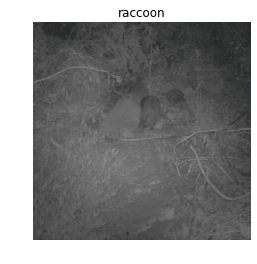

In [12]:
show_img(train_set[4055][0], title=class_names[train_set[4055][1]])

## Transfer Learning

### 1. Load a pretrained model and reset final fully connected layer
Here we used the DenseNet 201. The pretrained model weights are loaded from Kaggle dataset.

In [13]:
!ls ../input/vgg16

vgg16.pth


In [14]:
# Load a pretrained model
model_ft = models.vgg16(pretrained=False)
model_ft.load_state_dict(torch.load('../input/vgg16/vgg16.pth'))

# Freeze all the network except the final layer
for param in model_ft.parameters():
    param.requires_grad = False

# Alter the Linear layer for our classification problem
#num_ftrs = model_ft.fc.in_features
model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=len(class_names))

#model_ft.fc = nn.Linear(num_ftrs, len(class_names))

### 2. Train the model we defined

In [15]:
# The train_model function defined in Deep Learning course's homework.
# Here we altered the function so that the best_model_weights would be saved.
def train_model(model, loss_fn, batchSize, trainset, valset, optimizer, num_epochs=5, num_workers=4):
  
    # Shuffling is needed in case dataset is not shuffled by default.
    train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                               batch_size = batchSize,
                                               num_workers = num_workers,
                                               shuffle = True)
    # We don't need to bach the validation set but let's do it anyway.
    val_loader = torch.utils.data.DataLoader(dataset = valset,
                                             batch_size = batchSize,
                                             num_workers = num_workers,
                                             shuffle = False) # No need.

    # log accuracies and losses.
    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []

    # GPU enabling.
    model = model.cuda()
    loss_fn = loss_fn.cuda()
    
    # Save the initial model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Training loop. 
    for epoch in range(0, num_epochs):
        correct = 0.0
        cum_loss = 0.0

        # Make a pass over the training data.
        model.train()
        for (i, (inputs, labels)) in enumerate(train_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            loss = loss_fn(scores, labels)

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()
            cum_loss += loss.item()

            # Zero the gradients in the network.
            optimizer.zero_grad()

            # Backward pass. (Gradient computation stage)
            loss.backward()

            # Parameter updates (SGD step)
            optimizer.step()

            # Logging the current results on training.
            if (i + 1) % 100 == 0:
                print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

        train_accuracies.append(correct / len(trainset))
        train_losses.append(cum_loss / (i + 1))   

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels)) in enumerate(val_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            cum_loss += loss_fn(scores, labels).item()

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()

        val_accuracies.append(correct / len(valset))
        val_losses.append(cum_loss / (i + 1))
    
        # We should keep saving the best model: deep copy the model
        if (correct / len(valset)) > best_acc:
            best_acc = (correct / len(valset))
            best_model_wts = copy.deepcopy(model.state_dict())

        # Logging the current results on validation.
        print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(valset)))
    
    # Before return, we should set the model with the best model weights
    model.load_state_dict(best_model_wts)
    
    # Plot the losses & accuracies
    x = range(num_epochs)
    
    plt.figure()
    plt.plot(x, train_accuracies)
    plt.plot(x, val_accuracies)
    plt.title('Accuracy')
    plt.legend(['train_accuracy', 'val_accuracy'])
    
    plt.figure()
    plt.plot(x, train_losses)
    plt.plot(x, val_losses)
    plt.title('Loss')
    plt.legend(['train_loss', 'val_loss'])

In [16]:
batchSize = 80
loss_fn = nn.CrossEntropyLoss()
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, momentum=0.9)

# Train model
train_model(model_ft, loss_fn, batchSize, train_set, val_set, optimizer_ft, num_epochs=100) #epochs = 50

TypeError: __init__() got an unexpected keyword argument 'momentum'

## Model Evaluation

### 1. Get the result in validation set
Confusion matrix.

In [17]:
# Function we used during model evaluation.
def eval_predict(model, val_set, batchSize, num_workers=4):
    val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                             batch_size = batchSize,
                                             num_workers = num_workers,
                                             shuffle = False)
    
    input_list = []
    label_list = []
    score_list = []
    
    model = model.cuda()
    model.eval()
    for (i, (inputs, labels)) in enumerate(val_loader):
        inputs = inputs.cuda()

        # Forward pass. (Prediction stage)
        scores = model(inputs)
        
        for (input, label, score) in zip(inputs, labels, scores):
            input_list.append(input.cpu())
            label_list.append(label.item())
            score_list.append(score.cpu())

        if (i + 1) % 100 == 0:
            print('Predicted %06d images' % (i * batchSize + len(ids)) )
    
    return input_list, label_list, score_list

In [18]:
# Predict on the validation set.
input_list, label_list, score_list = eval_predict(model_ft, val_set, 100)

In [19]:
# Get the predicted labels list.
pred_list = [score.max(0)[1].item() for score in score_list]

In [20]:
print(len(class_names))

23


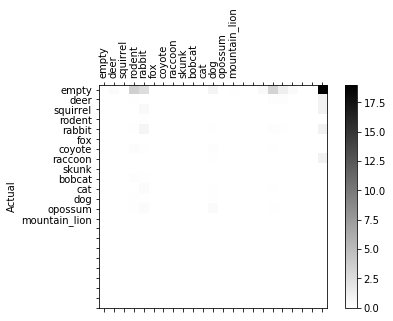

In [21]:
df_confusion = pd.crosstab(pd.Series(label_list, name='Actual'), pd.Series(pred_list, name='Predicted'))
df_conf_norm = df_confusion/ df_confusion.sum(axis=1)
import matplotlib.pyplot as plt
y = df_confusion.index.values
names = []
for i in y:
    names.append(class_names[i])

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, [i for i in names], rotation=90)
    plt.yticks(tick_marks, [i for i in names])
    
    
    #x = int(df_confusion.columns.values)
    #y = int(df_confusion.index.values)
    #plt.xticks(tick_marks, class_names[x], rotation=90)
    #plt.yticks(tick_marks, class_names[x])
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)


### 2. Show misclassified images
We want to explore which type of images are mostly being misclassified.

In [22]:
misclassfied_imgs = []
misclassfied_labels = []
original_labels = []

for(i, (input, label, pred)) in enumerate(zip(input_list, label_list, pred_list)):
    if(label != pred):
        img = input.clone()
        misclassfied_imgs.append(img)
        misclassfied_labels.append(class_names[pred])
        original_labels.append(label)
    
    if(i > 300):
        break

### Mis-classifled Samples

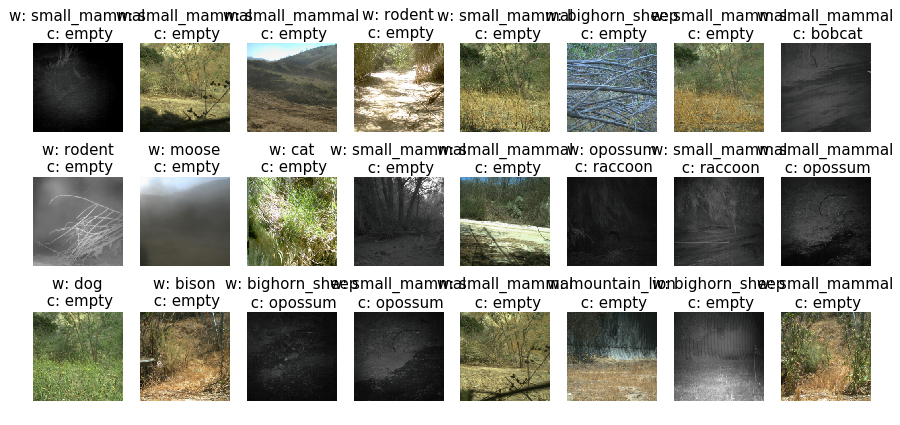

In [23]:
import math
fig = plt.figure(figsize=(15,7))
for i in range(0, 24):
    img = misclassfied_imgs[i].clone()
    # undo img transformations.
    img = img.squeeze() # get rid of batch dim.
    # un-normalize pixel values.
    for t, m, s in zip(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    #plt.title(title)
    #plt.imshow(img.transpose(0,2).transpose(0,1)); 
    if((i/8) <= 1):
        rows = 1
    else:
        rows = math.floor(i/8)+1
    if((i+1) % 8 == 0):
        cols = 1
    else:
        cols = (i+1) % 8
    ax = plt.subplot(3, 8, i+1)
    plt.axis('off')
    ax.set_title('w: %s' % misclassfied_labels[i]+'\n c: %s' % class_names[original_labels[i]], fontsize = 15)
    ax.imshow(img.transpose(0,2).transpose(0,1))

### Correctly Classified Samples

In [24]:
classfied_imgs = []
classfied_labels = []

for(i, (input, label, pred)) in enumerate(zip(input_list, label_list, pred_list)):
    if(label == pred):
        img = input.clone()
        classfied_imgs.append(img)
        classfied_labels.append(class_names[pred])
        #original_labels.append(label)
    
    if(i > 300):
        break

IndexError: list index out of range

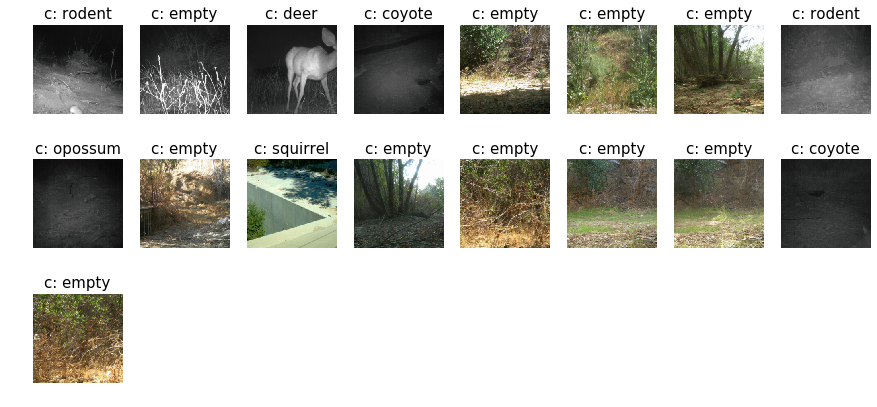

In [25]:
fig = plt.figure(figsize=(15,7))
for i in range(0, 24):
    img = classfied_imgs[i].clone()
    # undo img transformations.
    img = img.squeeze() # get rid of batch dim.
    # un-normalize pixel values.
    for t, m, s in zip(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    #plt.title(title)
    #plt.imshow(img.transpose(0,2).transpose(0,1)); 
    if((i/8) <= 1):
        rows = 1
    else:
        rows = math.floor(i/8)+1
    if((i+1) % 8 == 0):
        cols = 1
    else:
        cols = (i+1) % 8
    ax = plt.subplot(3, 8, i+1)
    plt.axis('off')
    ax.set_title('c: %s' % classfied_labels[i], fontsize = 15)
    ax.imshow(img.transpose(0,2).transpose(0,1))

## Submission: using trained model to get predicted classes

In [26]:
def predict(model, test_set, batchSize, num_workers=4):
    test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                             batch_size = batchSize,
                                             num_workers = num_workers,
                                             shuffle = False)
    
    submission = []
    
    model = model.cuda()
    model.eval()
    for (i, (inputs, ids)) in enumerate(test_loader):
        inputs = inputs.cuda()

        # Forward pass. (Prediction stage)
        scores = model(inputs)
        
        # Get predictions.
        _, max_labels = scores.max(1)
        
        # Add all the id & output into submission list
        for (id, max_label) in zip(ids, max_labels):
            submission.append({'Id':id, 'Predicted': max_label.item()})
        
        if (i + 1) % 100 == 0:
            print('Predicted %06d images' % (i * batchSize + len(ids)) )
    
    return pd.DataFrame(submission)

In [27]:
# Run predict session
batchSize = 100

submission_df = predict(model_ft, test_set, batchSize)

Predicted 010000 images
Predicted 020000 images
Predicted 030000 images
Predicted 040000 images
Predicted 050000 images
Predicted 060000 images
Predicted 070000 images
Predicted 080000 images
Predicted 090000 images
Predicted 100000 images
Predicted 110000 images
Predicted 120000 images
Predicted 130000 images
Predicted 140000 images
Predicted 150000 images


In [28]:
# Check the size of the output file: should be the same as the number of test images.
len(submission_df)

153730

In [29]:
# Output to submission.csv
submission_df.to_csv('submission.csv',index=False)